# EUR Predictor

Directory contains minute by minute prices of EUR/USD for the past 10 years (with the exception of 2014).  

This Notebook will build a RNN Model to predict the movement of the EUR prices based of historical minute by minute data.

Training and testing is easily separated by picking a year for training and another year for testing.  This, however, is not a great practice as training and testing sets are not equaly and randomly represented.  You will need to change the code to get better representation of training and testing.

For the purposes of playing around, you can play with Hyperparameters to design your model.



### Import the  libraries

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


### Defining Hyperparameters

In [105]:
# Define the sequence of minutes you want to train on 
SEQUENCE_TIMEPOINTS = 20  # 5-50   

# Define how many LSTM Cells you need to have per each Layer
LSTM_UNITS = 40 

# Single Layer will be an LSTM Layer, combined with Dropout layer
# Define how many of these you want to have stacked (minimum of 2 needed)
LSTM_LAYERS = 4
DROPOUT_RATE = 0.3

EPOCHS = 100
BATCH_SIZE = 32

OPTIMIZER = 'adam'
LOSS = 'mean_squared_error'

# Training and Testing
# Pick a year for Training and a year for Testing.  This is just a suggested easy way
# to demonstrate the process.  To build a better model, you will need to mix things around
# and randomly chose testing sequences (maybe with a mod function), this will be a better 
# sampling for both training and test data
TRAINING_YEAR='2018'
TESTING_YEAR='2017'

### Load the data

Data is orgainized in csv files marked by a year, containing minute by minute price information

In [106]:
dataset_train = pd.read_csv(TRAINING_YEAR+'.csv')

# Restrict the dataset to either:  just prices
training_set = dataset_train.iloc[:,2:3]

# or Date, time, and pricess, if you want to train on all 3
#   this is if you want to derive some good info from the date/time like:
#    month of the year, time of day, day in the week, weekend or not, etc
# training_set = dataset_train.iloc[:,2:3]


In [107]:
training_set

,OpenBid
0,1.20037
1,1.20083
2,1.20035
3,1.20041
4,1.20049
5,1.20050
6,1.20050
7,1.20048
8,1.20051
9,1.20082


### Feature scaling

Best thing is to scale the prices from 0 to 1

In [108]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled =sc.fit_transform(training_set)

In [109]:
training_set_scaled 

array([[0.58856075],
       [0.592     ],
       [0.58841121],
       ...,
       [0.18519626],
       [0.18542056],
       [0.18736449]])

### Creating a data structure for training

Each data point will have previous number of points for RNN training

In [110]:
X_train = []
y_train = []
for i in range(SEQUENCE_TIMEPOINTS, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-SEQUENCE_TIMEPOINTS:i,0])
    y_train.append(training_set_scaled[i,0])
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Build the RNN

In [111]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


In [112]:
regressor = Sequential()

# Layer 1
regressor.add(LSTM(units=LSTM_UNITS, return_sequences=True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(DROPOUT_RATE))

# Layer 2 to n-1
for i in range(LSTM_LAYERS-2):
    regressor.add(LSTM(units=LSTM_UNITS, return_sequences=True))
    regressor.add(Dropout(DROPOUT_RATE))

# Last LSTM Layer
regressor.add(LSTM(units=LSTM_UNITS))
regressor.add(Dropout(DROPOUT_RATE))

# Last layer to predict -  Only one Item to predict - EURO price at time
regressor.add(Dense(units = 1))

#### Show what model looks like

In [113]:
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 2, 4)              96        
_________________________________________________________________
dropout_8 (Dropout)          (None, 2, 4)              0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 4)                 144       
_________________________________________________________________
dropout_9 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


#### Set some hyperparameters and train 

In [114]:
regressor.compile(optimizer=OPTIMIZER,  loss=LOSS)
regressor.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/100
372605/372605 [==============================] - 33s 88us/step - loss: 0.0236
Epoch 2/100
372605/372605 [==============================] - 34s 90us/step - loss: 0.0187
Epoch 3/100
372605/372605 [==============================] - 41s 109us/step - loss: 0.0185
Epoch 4/100
372605/372605 [==============================] - 41s 110us/step - loss: 0.0183
Epoch 5/100
372605/372605 [==============================] - 40s 108us/step - loss: 0.0182
Epoch 6/100
372605/372605 [==============================] - 41s 111us/step - loss: 0.0181
Epoch 7/100
372605/372605 [==============================] - ETA: 0s - loss: 0.017 - 45s 120us/step - loss: 0.0179
Epoch 8/100
372605/372605 [==============================] - 43s 115us/step - loss: 0.0175
Epoch 9/100
372605/372605 [==============================] - 44s 117us/step - loss: 0.0174
Epoch 10/100
372605/372605 [==============================] - 45s 120us/step - loss: 0.0174
Epoch 11/100
372605/372605 [==============================] - 46s 1

372605/372605 [==============================] - 44s 118us/step - loss: 0.0165
Epoch 90/100
372605/372605 [==============================] - 45s 121us/step - loss: 0.0164
Epoch 91/100
372605/372605 [==============================] - 43s 116us/step - loss: 0.0164
Epoch 92/100
372605/372605 [==============================] - 46s 124us/step - loss: 0.0164
Epoch 93/100
372605/372605 [==============================] - 45s 120us/step - loss: 0.0164
Epoch 94/100
372605/372605 [==============================] - 44s 117us/step - loss: 0.0163
Epoch 95/100
372605/372605 [==============================] - 43s 114us/step - loss: 0.0163
Epoch 96/100
372605/372605 [==============================] - 44s 117us/step - loss: 0.0164
Epoch 97/100
372605/372605 [==============================] - 43s 115us/step - loss: 0.0164
Epoch 98/100
372605/372605 [==============================] - 41s 110us/step - loss: 0.0163
Epoch 99/100
372605/372605 [==============================] - 42s 112us/step - loss: 0.0164
E

### Trying to setup testing on my own

In [103]:
dataset_test = pd.read_csv(TESTING_YEAR+'.csv')

# Restrict the dataset to either:  just prices
testing_set = dataset_test.iloc[:,2:3]
real_eur_price = testing_set.values

In [104]:
real_eur_price

array([[1.05155],
       [1.05209],
       [1.05177],
       ...,
       [1.19969],
       [1.20009],
       [1.19982]])

#### Load the real fx data for the  testing set

Save for later
dataset_total = pd.concat( (dataset_train['OpenBid'],dataset_test['OpenBid']), axis=0)
inputs = dataset_test[len(dataset_test)-SEQUENCE_TIMEPOINTS-60: ]

#### Second: Scale and predict the data

In [58]:
inputs = testing_set.values
inputs = inputs.reshape(-1,1)
inputs_backup=inputs.copy()    # Keep the unscalled version 

inputs = sc.transform(inputs)

In [59]:
len(inputs)

371635

In [61]:
X_test = []
real_eur = []
for i in range(SEQUENCE_TIMEPOINTS+1, len(inputs)-1):
    X_test.append(inputs[i-SEQUENCE_TIMEPOINTS:i, 0])
    real_eur.append(inputs_backup[i,0])
    

X_test = np.array(X_test)

#X_test


In [52]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [53]:
predicted_eur = regressor.predict(X_test)
# descale
predicted_eur = sc.inverse_transform(predicted_eur)



####  Visualize results

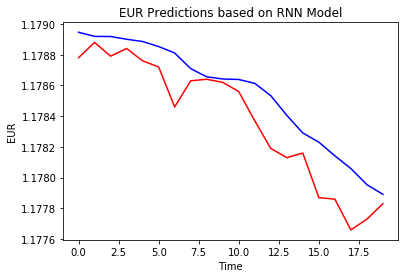

In [77]:
plt.plot(real_eur[360000:360020], color='red', label='Real EUR')
plt.plot(predicted_eur[360000:360020], color='blue', label='Predicted EUR')
plt.title("EUR Predictions based on RNN Model")
plt.xlabel("Time")
plt.ylabel("EUR")
plt.show()